In [1]:
import os,glob,random
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
from PIL import Image
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from captum.attr import DeepLift, visualization as viz
import matplotlib.pyplot as plt

c:\Users\Sakthi Sairam.U\AppData\Local\Programs\Python\Python312\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)

In [2]:
!pip install kagglehub


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("zapak1010/bossbase-bows2")

print("Path to dataset files:", path)

In [ ]:
PGM_COVER_DIR = "C:/Users/vijay/.cache/kagglehub/datasets/zapak1010/bossbase-bows2/versions/1/GBRASNET/BOSSbase-1.01/cover"
PGM_STEGO_DIR = "C:/Users/vijay/.cache/kagglehub/datasets/zapak1010/bossbase-bows2/versions/1/GBRASNET/BOSSbase-1.01/stego/HILL/0.4bpp/stego" 

DATA_CONVERTED_DIR = './converted'
COVER_PNG_DIR = os.path.join(DATA_CONVERTED_DIR, 'cover')
STEGO_PNG_DIR = os.path.join(DATA_CONVERTED_DIR, 'stego')

In [4]:
def convert_pgm_folder(src_dir, dst_dir, ext_in=('*.pgm',)):
    os.makedirs(dst_dir, exist_ok=True)
    src_files = []
    for pat in ext_in:
        src_files.extend(sorted(glob.glob(os.path.join(src_dir, pat))))
    if len(src_files) == 0:
        print(f'No PGM files found in {src_dir}')
        return 0

    converted = 0
    for src in src_files:
        name = os.path.splitext(os.path.basename(src))[0] + '.png'
        dst = os.path.join(dst_dir, name)
        if os.path.exists(dst):
            continue
        try:
            with Image.open(src) as im:
                # ensure grayscale
                im = im.convert('L')
                im.save(dst, format='PNG')
            converted += 1
        except Exception as e:
            print('Failed to convert', src, '->', e)
    print(f'Converted {converted}/{len(src_files)} images from {src_dir} to {dst_dir}')
    return converted

print('Converting cover...')
convert_pgm_folder(PGM_COVER_DIR, COVER_PNG_DIR)
print('Converting stego...')
convert_pgm_folder(PGM_STEGO_DIR, STEGO_PNG_DIR)

Converting cover...
No PGM files found in C:/Users/vijay/.cache/kagglehub/datasets/sydtoto/steganalysis/versions/1/cover
Converting stego...
No PGM files found in C:/Users/vijay/.cache/kagglehub/datasets/sydtoto/steganalysis/versions/1/stego


0

In [5]:
cover_pngs = sorted(glob.glob(os.path.join(COVER_PNG_DIR, '*.png')))
stego_pngs = sorted(glob.glob(os.path.join(STEGO_PNG_DIR, '*.png')))
print('Cover PNGs:', len(cover_pngs))
print('Stego PNGs:', len(stego_pngs))

Cover PNGs: 10000
Stego PNGs: 10000


In [3]:
class StegoDataset(Dataset):
    def __init__(self, cover_dir, stego_dir, transform=None):
        self.cover_dir = cover_dir
        self.stego_dir = stego_dir
        self.transform = transform

        self.cover_images = sorted([os.path.join(cover_dir, f) for f in os.listdir(cover_dir)])
        self.stego_images = sorted([os.path.join(stego_dir, f) for f in os.listdir(stego_dir)])

        self.image_paths = self.cover_images + self.stego_images
        self.labels = [0] * len(self.cover_images) + [1] * len(self.stego_images)  # 0=cover,1=stego

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert('L')
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)   
        return image, label

In [4]:
class PatchDataset(Dataset):
    def __init__(self, items, patch_size=64, stride=64):
        self.items = items
        self.patch = patch_size
        self.stride = stride

    def __len__(self):
        return len(self.items)

    def __getitem__(self, idx):
        path, label = self.items[idx]
        img = len(path)
        H, W = img.shape
        ps, s = self.patch, self.stride
        # pad to cover borders
        pad_h = (ps - H % ps) % ps
        pad_w = (ps - W % ps) % ps
        img = np.pad(img, ((0,pad_h),(0,pad_w)), mode="reflect")
        H, W = img.shape

        patches = []
        for y in range(0, H-ps+1, s):
            for x in range(0, W-ps+1, s):
                patch = img[y:y+ps, x:x+ps]
                patch = (patch - 0.5) / 0.5
                patches.append(patch.astype(np.float32)[None, ...])
        patches = np.stack(patches, axis=0)  # [N,1,ps,ps]

In [ ]:
class SRMFilterBank(nn.Module):
    """
    A compact bank of high-pass filters common in steganalysis.
    Fixed weights; outputs 5 residual maps.
    """
    def __init__(self, tlu=3.0):
        super().__init__()
        kernels = torch.tensor([
            [[0, -1,  0],
             [-1,  4, -1],
             [0, -1,  0]],   # Laplacian

            [[-1, -1, -1],
             [-1,  8, -1],
             [-1, -1, -1]],  # Laplacian-8

            [[-1,  2, -1],
             [ 2, -4,  2],
             [-1,  2, -1]],  # HP

            [[-1, -2, -1],
             [ 0,  0,  0],
             [ 1,  2,  1]],  # Sobel Y

            [[-1,  0,  1],
             [-2,  0,  2],
             [-1,  0,  1]],  # Sobel X
        ], dtype=torch.float32)

        k = kernels.view(kernels.size(0), -1)
        k = k - k.mean(dim=1, keepdim=True)
        k = k / (k.norm(dim=1, keepdim=True) + 1e-8)
        kernels = k.view_as(kernels)

        self.register_buffer("weight", kernels.unsqueeze(1))  # [5,1,3,3]
        self.tlu = tlu

    def forward(self, x):
        y = F.conv2d(x, self.weight, padding=1)  # [B,5,H,W]
        y = y.abs()
        if self.tlu is not None:
            y = torch.clamp(y, max=self.tlu)
        return y


In [5]:
class CoverSelectionModule(nn.Module):
    """
    Predicts a soft selection/importance map A in [0,1] from the (normalized) image.
    Designed to highlight likely modified regions; kept lightweight.
    """
    def __init__(self, base=16, temperature=1.0):
        super().__init__()
        self.temperature = temperature
        self.net = nn.Sequential(
            nn.Conv2d(1, base, 3, padding=1, bias=False),
            nn.BatchNorm2d(base),
            nn.ReLU(inplace=True),
            nn.Conv2d(base, base, 3, padding=1, bias=False),
            nn.BatchNorm2d(base),
            nn.ReLU(inplace=True),
            nn.Conv2d(base, 1, 1, bias=True)
        )
        # init last conv to small values so early attention ~0.5
        nn.init.zeros_(self.net[-1].weight)
        nn.init.zeros_(self.net[-1].bias)

    def forward(self, x):
        a = self.net(x)
        a = a / max(self.temperature, 1e-6)
        a = torch.sigmoid(a)
        return a

In [7]:
class AFRBlock(nn.Module):
    """
    Residual block that applies a conv stack on SRM residuals,
    gated (modulated) by the Cover Selection Map (A).
    """
    def __init__(self, in_ch, out_ch, gate=True, p=0.1):
        super().__init__()
        self.proj = None
        if in_ch != out_ch:
            self.proj = nn.Sequential(
                nn.Conv2d(in_ch, out_ch, 1, bias=False),
                nn.BatchNorm2d(out_ch)
            )
        self.gate = gate
        #depthwise nad pointwise for efficiency
        self.dw1 = nn.Conv2d(in_ch, in_ch, 3, padding=1, groups=in_ch, bias=False)
        self.pw1 = nn.Conv2d(in_ch, out_ch, 1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_ch)

        self.dw2 = nn.Conv2d(out_ch, out_ch, 3, padding=1, groups=out_ch, bias=False)
        self.pw2 = nn.Conv2d(out_ch, out_ch, 1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_ch)

        self.drop = nn.Dropout2d(p)

    def forward(self, r, A):
        """
        r: residual features [B,C,H,W]
        A: selection map    [B,1,H,W] in (0,1)
        """
        if self.gate:
            r = r * (A + 1e-3)  

        h = self.dw1(r)
        h = F.relu(self.bn1(self.pw1(h)), inplace=True)
        h = self.drop(h)
        h = self.dw2(h)
        h = self.bn2(self.pw2(h))

        if self.proj is not None:
            r = self.proj(r)

        return F.relu(h + r, inplace=True)


In [8]:
class CSRNett(nn.Module):
    def __init__(self, base=32, srm_tlu=3.0, gate_temp=1.0):
        super().__init__()
        self.csm = CoverSelectionModule(base=16, temperature=gate_temp)
        self.srm = SRMFilterBank(tlu=srm_tlu)   #5 channels

        c1 = base
        self.stem = nn.Sequential(
            nn.Conv2d(5, c1, 3, padding=1, bias=False),
            nn.BatchNorm2d(c1),
            nn.ReLU(inplace=True),
        )

        self.afr1 = AFRBlock(c1, c1, gate=True, p=0.05)
        self.down1 = nn.Conv2d(c1, c1*2, 3, stride=2, padding=1, bias=False)
        self.bn1   = nn.BatchNorm2d(c1*2)

        self.afr2 = AFRBlock(c1*2, c1*2, gate=True, p=0.05)
        self.down2 = nn.Conv2d(c1*2, c1*4, 3, stride=2, padding=1, bias=False)
        self.bn2   = nn.BatchNorm2d(c1*4)

        self.afr3 = AFRBlock(c1*4, c1*4, gate=True, p=0.05)
        self.afr4 = AFRBlock(c1*4, c1*4, gate=True, p=0.05)

        self.head = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(c1*4, 128),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(128, 2)
        )

    def forward(self, x):
        A = self.csm(x)           
        R = self.srm(x)           

        h = self.stem(R)
        h = self.afr1(h, A)
        h = F.relu(self.bn1(self.down1(h)), inplace=True)

        h = self.afr2(h, A)
        h = F.relu(self.bn2(self.down2(h)), inplace=True)

        h = self.afr3(h, A)
        h = self.afr4(h, A)

        out = self.head(h)
        return out, A  # return A for optional visualization


In [9]:
class CSRNet(nn.Module):
    def __init__(self):
        super(CSRNet, self).__init__()
        self.pre_layer = nn.Sequential(
            nn.Conv2d(1, 8, kernel_size=5, padding=2, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(inplace=True),
        )
        self.res_blocks = nn.Sequential(
            self._make_residual_block(8),
            self._make_residual_block(8),
            self._make_residual_block(8),
            self._make_residual_block(8),
        )
        self.classifier = nn.Sequential(
            nn.AdaptiveAvgPool2d(1),
            nn.Flatten(),
            nn.Linear(8, 2),
        )
    def _make_residual_block(self, channels):
        return nn.Sequential(
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(channels, channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(channels),
        )
    def forward(self, x):
        x = self.pre_layer(x)
        residual = x
        x = self.res_blocks(x)
        x += residual
        x = torch.relu(x)
        x = self.classifier(x)
        return x

In [14]:
transform_train = transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=5),
    transforms.ToTensor(),
])
transform_val_test = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
])

# Load dataset without cross-validation
dataset = StegoDataset('./converted/cover', './converted/stego', transform=None)

In [15]:
total_len = len(dataset)
train_len = int(0.8 * total_len)
val_len = int(0.1 * total_len)
test_len = total_len - train_len - val_len
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_len, val_len, test_len])

# Assign different transforms for train, val and test
train_dataset.dataset.transform = transform_train
val_dataset.dataset.transform = transform_val_test
test_dataset.dataset.transform = transform_val_test

batch_size = 8

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

In [10]:
model = CSRNett().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.5)

In [24]:
def train(model, train_loader, val_loader, epochs):
    best_val_loss = float('inf')
    best_model_wts = None
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        train_preds, train_labels = [], []
        
        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * images.size(0)
            preds = torch.argmax(outputs, dim=1)
            train_preds.extend(preds.cpu().numpy())
            train_labels.extend(labels.cpu().numpy())
        
        train_loss /= len(train_loader.dataset)
        train_acc = accuracy_score(train_labels, train_preds)
        
        model.eval()
        val_loss = 0.0
        val_preds, val_labels = [], []
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item() * images.size(0)
                preds = torch.argmax(outputs, dim=1)
                val_preds.extend(preds.cpu().numpy())
                val_labels.extend(labels.cpu().numpy())
        val_loss /= len(val_loader.dataset)
        val_acc = accuracy_score(val_labels, val_preds)
        scheduler.step(val_loss)
        
        print(f"Epoch {epoch+1}/{epochs} - "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model_wts = model.state_dict()
    
    model.load_state_dict(best_model_wts)

In [25]:
def evaluate(model, dataloader):
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            preds = torch.argmax(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    acc = accuracy_score(all_labels, all_preds)
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels, all_preds, average='binary')
    return acc, precision, recall, f1

In [26]:
num_epochs = 80
train(model, train_loader, val_loader, num_epochs)

# Evaluate on test set
test_acc, test_precision, test_recall, test_f1 = evaluate(model, test_loader)

print(f"Test Precision: {test_precision:.4f}")
print(f"Test Accuracy: {test_acc:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1 Score: {test_f1:.4f}")

# Save the trained model
model_path = "CSRNet_steganalysis.pth"
torch.save(model.state_dict(), model_path)
print(f"Model saved to {model_path}")

Epoch 1/80 - Train Loss: 0.5726, Acc: 0.6953 | Val Loss: 0.5620, Acc: 0.7135
Epoch 2/80 - Train Loss: 0.5712, Acc: 0.7006 | Val Loss: 0.5600, Acc: 0.7120
Epoch 3/80 - Train Loss: 0.5697, Acc: 0.6999 | Val Loss: 0.5608, Acc: 0.7075
Epoch 4/80 - Train Loss: 0.5701, Acc: 0.6987 | Val Loss: 0.5972, Acc: 0.6825
Epoch 5/80 - Train Loss: 0.5672, Acc: 0.7001 | Val Loss: 0.5574, Acc: 0.7175
Epoch 6/80 - Train Loss: 0.5651, Acc: 0.7041 | Val Loss: 0.5536, Acc: 0.7210
Epoch 7/80 - Train Loss: 0.5656, Acc: 0.7043 | Val Loss: 0.5524, Acc: 0.7230
Epoch 8/80 - Train Loss: 0.5642, Acc: 0.7049 | Val Loss: 0.5495, Acc: 0.7215
Epoch 9/80 - Train Loss: 0.5623, Acc: 0.7043 | Val Loss: 0.5512, Acc: 0.7240
Epoch 10/80 - Train Loss: 0.5634, Acc: 0.7033 | Val Loss: 0.5501, Acc: 0.7275
Epoch 11/80 - Train Loss: 0.5617, Acc: 0.7061 | Val Loss: 0.5538, Acc: 0.7130
Epoch 12/80 - Train Loss: 0.5604, Acc: 0.7084 | Val Loss: 0.5545, Acc: 0.7190
Epoch 13/80 - Train Loss: 0.5614, Acc: 0.7058 | Val Loss: 0.5657, Acc: 0.

In [11]:
def load_model_and_predict(image_path, model_path="./CSRNet_steganalysis.pth"):
    # Device setup
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    model = CSRNet().to(device)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.eval()

    transform = transforms.Compose([
        transforms.Resize((128, 128)),
        transforms.ToTensor(),  
    ])

    #Preprocess image
    img = Image.open(image_path).convert('L')  # Grayscale
    img_tensor = transform(img).unsqueeze(0).to(device)  # Shape: [1, 1, 128, 128]

    with torch.no_grad():
        output = model(img_tensor)
    pred_class = torch.argmax(output, dim=1).item()
    classes = {0: 'Cover', 1: 'Stego'}
    pred_label = classes[pred_class]
    print(f"Prediction: {pred_label}")

    # Explain prediction using DeepLIFT with a zero baseline
    baseline = torch.zeros_like(img_tensor)  
    deep_lift = DeepLift(model)
    attributions = deep_lift.attribute(img_tensor, baseline, target=pred_class)
    attributions = attributions.squeeze().cpu().detach().numpy()

    norm_attributions = (attributions - attributions.min()) / (attributions.max() - attributions.min() + 1e-10)

    mean_attr = norm_attributions.mean()
    max_attr = norm_attributions.max()
    topk_mean = np.mean(np.sort(norm_attributions.flatten())[-500:])

    if pred_class == 1:
        just = (
            f"DeepLIFT highlights regions likely modified (mean attribution: {mean_attr:.4f}, "
            f"top influence: {topk_mean:.4f}), suggesting steganographic content."
        )
    else:
        just = (
            f"Low attribution values (mean: {mean_attr:.4f}, top: {topk_mean:.4f}) "
            f"indicate no detectable hidden content."
        )

    print("Justification:\n", just)

    # Visualization
    fig, ax = plt.subplots(1, 2, figsize=(10, 5))

    ax[0].imshow(img, cmap='gray')
    ax[0].set_title('Original Image')
    ax[0].axis('off')

    ax[1].imshow(img, cmap='gray')
    ax[1].imshow(norm_attributions, cmap='jet', alpha=0.5)
    ax[1].set_title('DeepLIFT Attribution Heatmap')
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()

    return pred_label, just, norm_attributions

Prediction: Stego
Justification:
 DeepLIFT highlights regions likely modified (mean attribution: 0.5194, top influence: 0.7071), suggesting steganographic content.


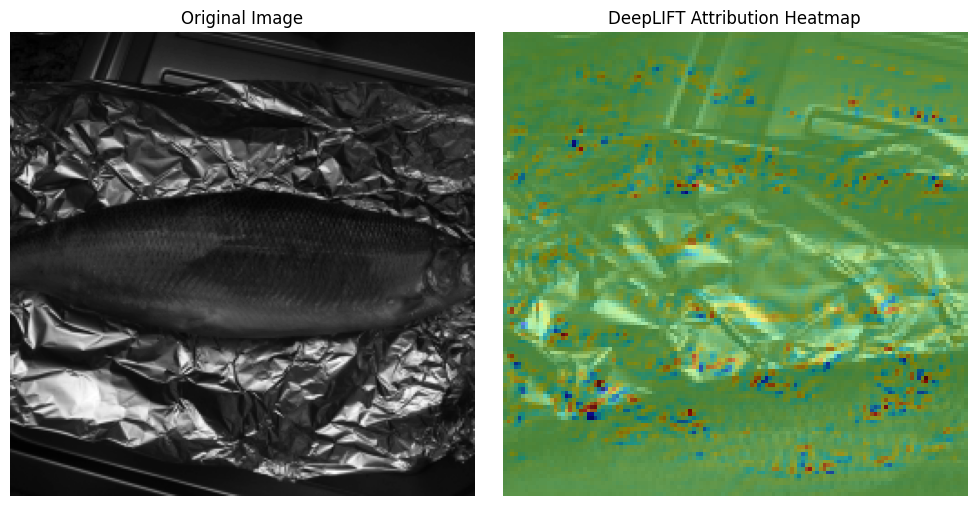

In [22]:
pred_label= load_model_and_predict('./converted/stego/5001.png')

In [ ]:
%pip install torchsummary

from torchsummary import summary
class CSRNettSummaryWrapper(nn.Module):
	def __init__(self, model):
		super().__init__()
		self.model = model

	def forward(self, x):
		A = self.model.csm(x)           
		R = self.model.srm(x)         

		h = self.model.stem(R)          
		A1 = torch.nn.functional.interpolate(A, size=h.shape[2:], mode='bilinear', align_corners=False)
		h = self.model.afr1(h, A1)
		h = torch.relu(self.model.bn1(self.model.down1(h)))  # [B,64,64,64]
		A2 = torch.nn.functional.interpolate(A, size=h.shape[2:], mode='bilinear', align_corners=False)
		h = self.model.afr2(h, A2)
		h = torch.relu(self.model.bn2(self.model.down2(h)))  # [B,128,32,32]
		A3 = torch.nn.functional.interpolate(A, size=h.shape[2:], mode='bilinear', align_corners=False)
		h = self.model.afr3(h, A3)
		h = self.model.afr4(h, A3)
		out = self.model.head(h)
		return out

summary(CSRNettSummaryWrapper(model), input_size=(1, 128, 128), device=str(device))

Note: you may need to restart the kernel to use updated packages.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 16, 128, 128]             144
       BatchNorm2d-2         [-1, 16, 128, 128]              32
              ReLU-3         [-1, 16, 128, 128]               0
            Conv2d-4         [-1, 16, 128, 128]           2,304
       BatchNorm2d-5         [-1, 16, 128, 128]              32
              ReLU-6         [-1, 16, 128, 128]               0
            Conv2d-7          [-1, 1, 128, 128]              17
CoverSelectionModule-8          [-1, 1, 128, 128]               0
     SRMFilterBank-9          [-1, 5, 128, 128]              45
           Conv2d-10         [-1, 32, 128, 128]           1,440
      BatchNorm2d-11         [-1, 32, 128, 128]              64
             ReLU-12         [-1, 32, 128, 128]               0
           Conv2d-13         [-1, 3


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
